In [1]:
import sys
import xarray as xr
import metpy.calc as mpcalc
import numpy as np
import pandas as pd
import math

import cartopy
import matplotlib.pyplot as plt
import cmocean.cm as cmo

# cartopy
import cartopy.crs as ccrs
from cartopy.mpl.geoaxes import GeoAxes
import cartopy.feature as cfeature


# import personal modules
# Path to modules
sys.path.append('../modules')
# Import my modules
from utils import roundPartial
from plotter import draw_basemap, plot_terrain
from trajectory import calculate_backward_trajectory

In [2]:
path_to_data = '/data/projects/Comet/cwp140/' 
path_to_out  = '../out/'       # output files (numerical results, intermediate datafiles) -- read & write
path_to_figs = '../figs/'      # figures

In [3]:
## set starting lat/lon
## choose this based on extreme precip days

fname = path_to_data + 'preprocessed/PRISM/PRISM_HUC8_CO.nc'
ds = xr.open_dataset(fname)
# start with single event from single watershed
ds = ds.isel(HUC8=0)
ds = ds.where(ds.extreme == 1, drop=True)

ds

FileNotFoundError: [Errno 2] No such file or directory: '/data/projects/Comet/cwp140/preprocessed/PRISM/PRISM_HUC8_CO.nc'

In [ ]:
idx = 5
## create list of dates based on start date
start_date = ds.isel(date=idx).date.values - np.timedelta64(3,'d')
end_date = ds.isel(date=idx).date.values

date_lst = pd.date_range(start_date, end_date, freq='1D')

# create list of daily ERA5 files for each AR
filenames = []
for j, date in enumerate(date_lst):
    year = date.year
    month = date.month
    day = date.day
    
    path_to_data = '/expanse/lustre/scratch/dnash/temp_project/downloaded/ERA5/{0}/'.format(year)
    fname = "era5_nhemi_025dg_1hr_uvwq_{0}{1}{2}.nc".format(year, month, day)
    
    filenames.append(path_to_data + fname)

# open all files within the AR period
ds1 = xr.open_mfdataset(filenames, combine='by_coords')

In [4]:
%%time
s = calculate_backward_trajectory(ds=ds, idx=5, start_lev=700.)
df = s.compute_trajectory()
df

2000-02-18T12:00:00.000000000 37.17830580993748 -108.52883134885546
CPU times: user 2 s, sys: 79.3 ms, total: 2.08 s
Wall time: 4.29 s


,time,latitude,longitude,level,q,u,v,w,dq,drying_ratio
0,2000-02-18T12:00:00.000000000,37.178306,-108.528831,700.0,2.561597,4.327077,-2.228128,0.104292,NaN,NaN
1,2000-02-18T11:00:00.000000000,37.250439,-108.668923,696.245471,2.54616,4.172208,-2.060112,0.121139,-0.015437,-0.606288
2,2000-02-18T10:00:00.000000000,37.317134,-108.804001,691.884481,2.582934,4.106739,-1.683754,0.113985,0.036774,1.423716
3,2000-02-18T09:00:00.000000000,37.371644,-108.936959,687.781003,2.632583,6.279771,-0.502022,-0.122843,0.049649,1.885953
4,2000-02-18T08:00:00.000000000,37.387896,-109.14027,692.203369,2.687979,6.435592,-0.408716,-0.162566,0.055396,2.060888
...,...,...,...,...,...,...,...,...,...,...
67,2000-02-15T17:00:00.000000000,31.978181,-123.888795,922.439234,4.316636,2.002775,2.445679,-0.054243,-0.055619,-1.288483
68,2000-02-15T16:00:00.000000000,31.899005,-123.953636,924.391968,4.323741,1.847828,2.567812,-0.09286,0.007105,0.164324
69,2000-02-15T15:00:00.000000000,31.815874,-124.01346,927.73494,4.286548,0.86412,2.708588,-0.043616,-0.037192,-0.867652
70,2000-02-15T14:00:00.000000000,31.728186,-124.041437,929.305123,4.3384,0.137171,2.313566,0.101767,0.051852,1.195176


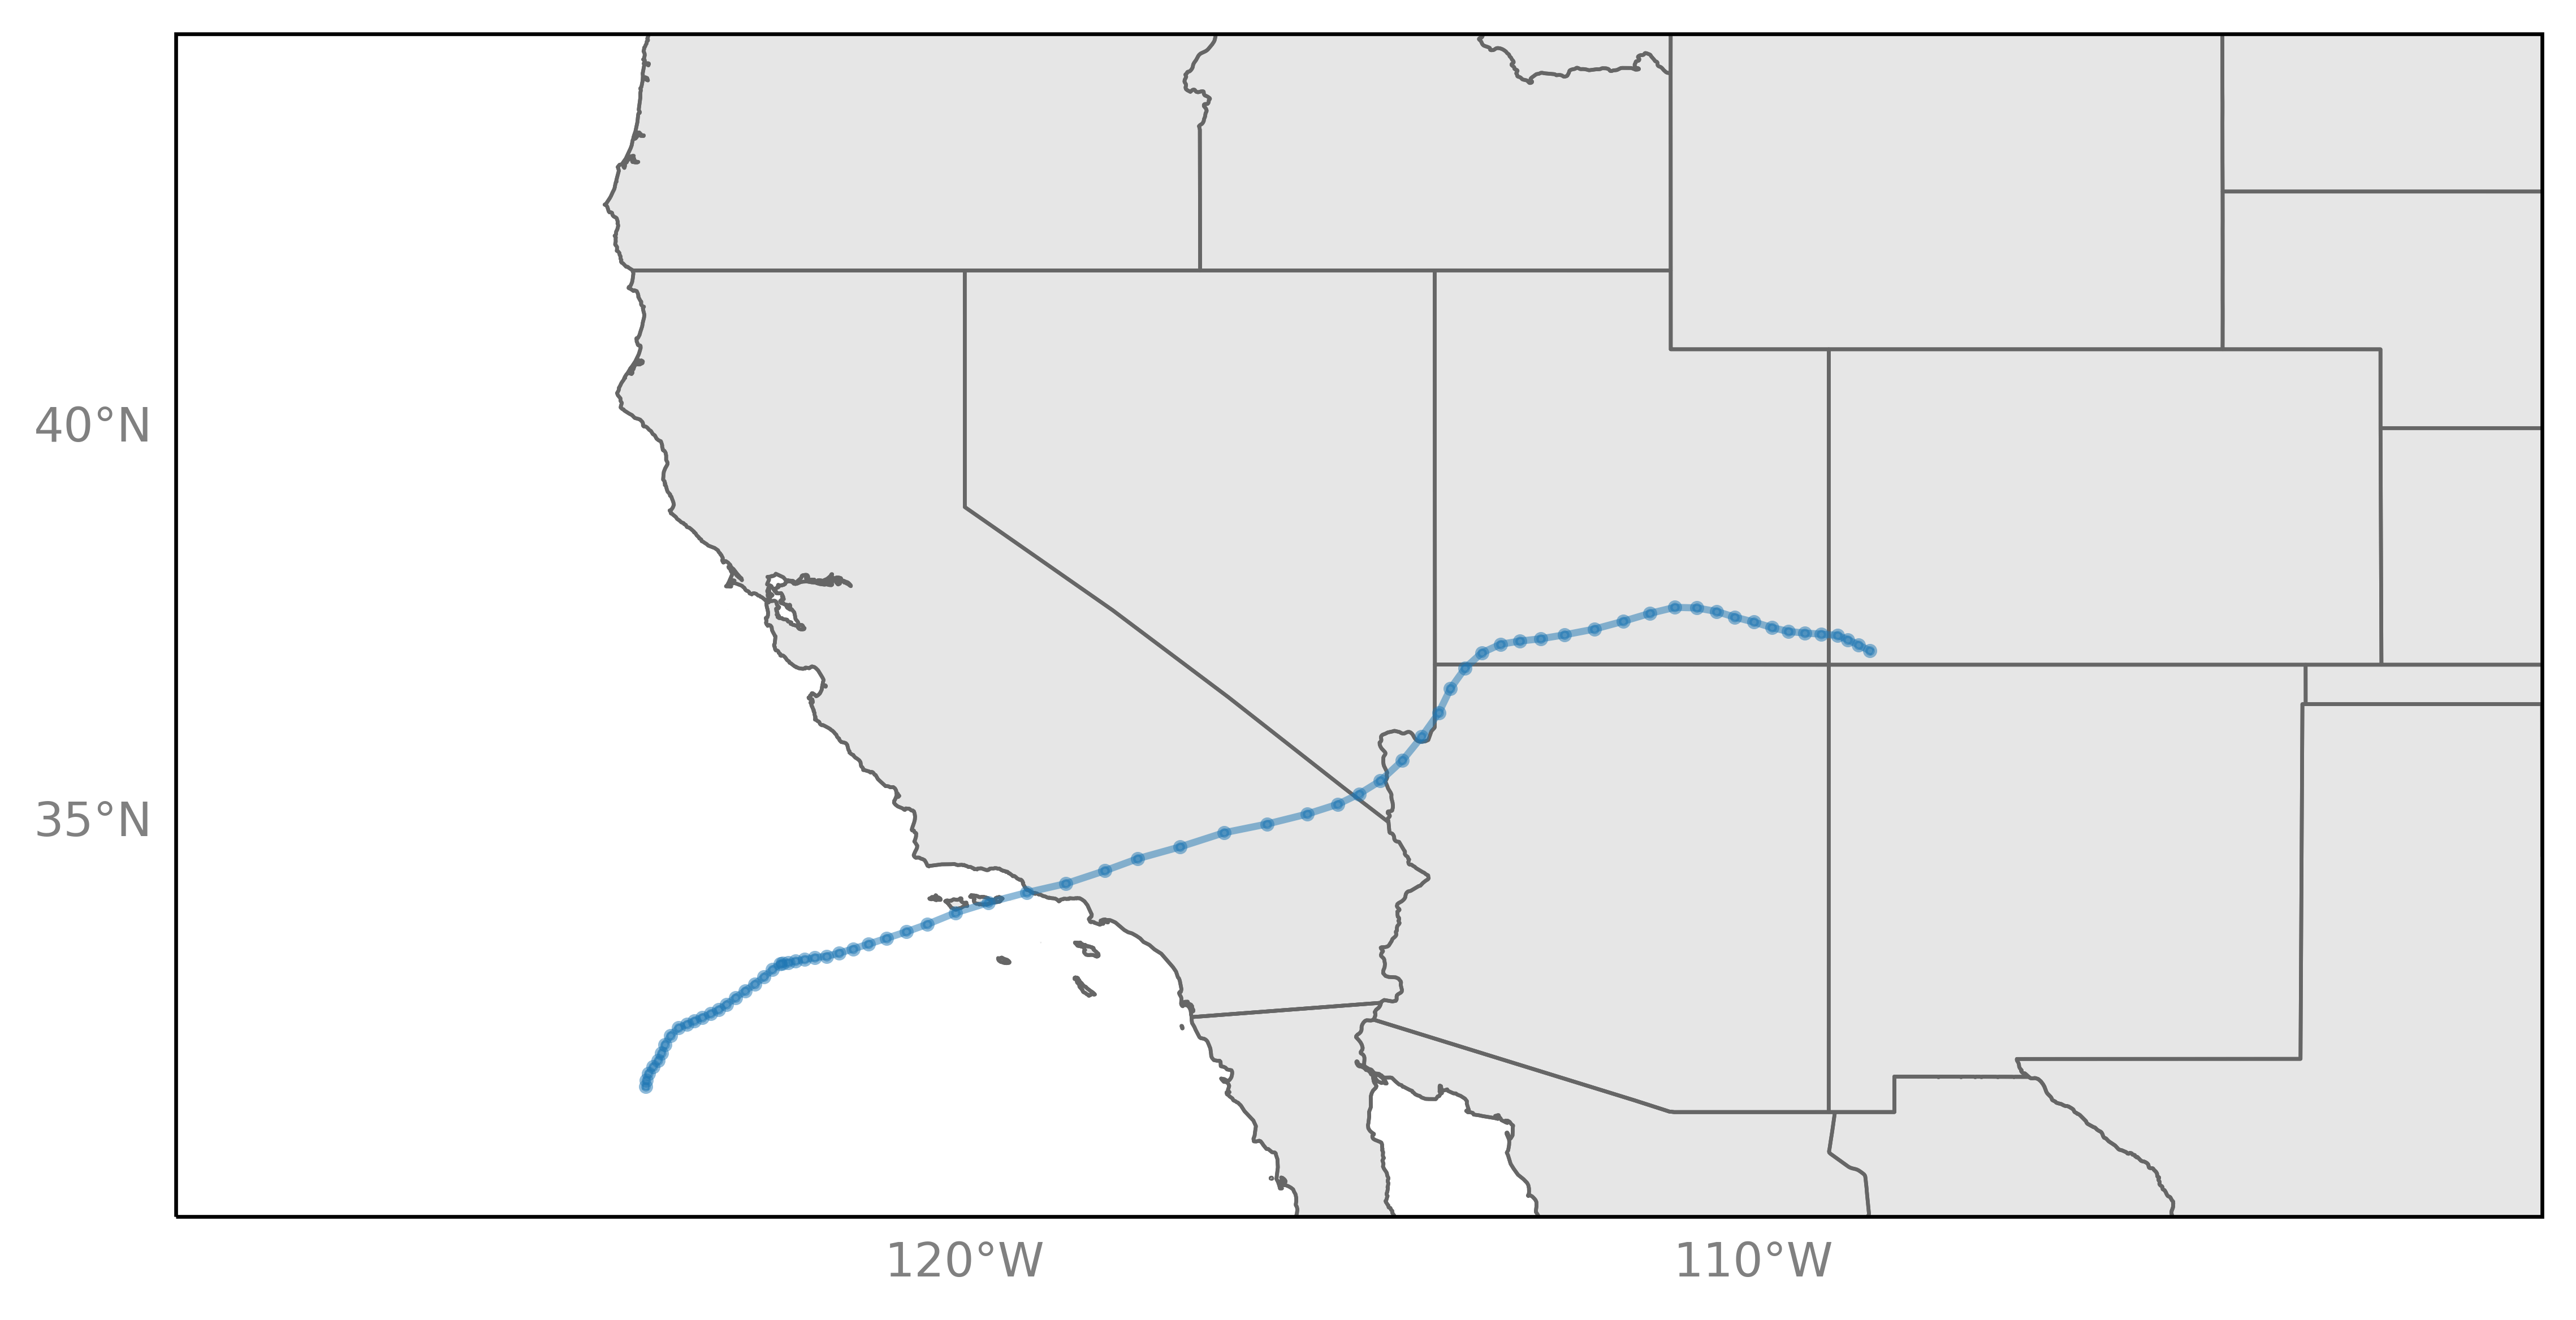

In [5]:
ext = [-130., -100., 30., 45.] 
fmt = 'png'

# Set up projection
datacrs = ccrs.PlateCarree()  ## the projection the data is in
mapcrs = ccrs.PlateCarree() ## the projection you want your map displayed in

# Set tick/grid locations
tx = 10
ty = 5
dx = np.arange(ext[0],ext[1]+tx,tx)
dy = np.arange(ext[2],ext[3]+ty,ty)

fig = plt.figure(figsize=(9.0 ,9.0))
fig.dpi = 600
fname = path_to_figs + 'test_trajectory'

ax = plt.axes(projection=mapcrs)
ax = draw_basemap(ax, extent=ext, xticks=dx, yticks=dy,left_lats=True, right_lats=False)
ax.set_extent(ext, datacrs)

ax.add_feature(cfeature.STATES, edgecolor='0.4', linewidth=0.8)

# need this to fix annotate transform
transform = datacrs._as_mpl_transform(ax)

## Add different points
y_lst = df.latitude.values
x_lst = df.longitude.values
ax.plot(x_lst, y_lst, 'o-', 'red', markersize=2, transform=datacrs, alpha=0.5)

## Add elevation contours
# ax = plot_terrain(ax, ext)

fig.savefig('%s.%s' %(fname, fmt), bbox_inches='tight', dpi=fig.dpi, transparent=True)
plt.show()
fig.clf()